In [53]:
import pandas as pd
import numpy as np
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
train.head()

,id,subject,email,spam
0,0,Subject: A&L Daily to be auctioned in bankrupt...,URL: http://boingboing.net/#85534171\n Date: N...,0
1,1,"Subject: Wired: ""Stronger ties between ISPs an...",URL: http://scriptingnews.userland.com/backiss...,0
2,2,Subject: It's just too small ...,<HTML>\n <HEAD>\n </HEAD>\n <BODY>\n <FONT SIZ...,1
3,3,Subject: liberal defnitions\n,Depends on how much over spending vs. how much...,0
4,4,Subject: RE: [ILUG] Newbie seeks advice - Suse...,hehe sorry but if you hit caps lock twice the ...,0


In [54]:
print(np.sum(np.array(train.isnull()==True), axis=0))
print(np.sum(np.array(test.isnull()==True), axis=0))
train = train.fillna(" ")
test = test.fillna(" ")
print(np.sum(np.array(train.isnull()==True), axis=0))
print(np.sum(np.array(test.isnull()==True), axis=0))
print(train['spam'].unique())

[0 6 0 0]
[0 1 0]
[0 0 0 0]
[0 0 0]
[0 1]


In [55]:
X_train = train['subject'] + ' ' + train['email']
y_train = train['spam']
X_test = test['subject'] + ' ' + test['email']

In [56]:
from keras.preprocessing.text import Tokenizer
max_words = 300
tokenizer = Tokenizer(num_words=max_words, lower=True, split=' ')
# 只给频率最高的300个词分配 id，其他的忽略
tokenizer.fit_on_texts(list(X_train)+list(X_test))
X_train_tokens = tokenizer.texts_to_sequences(X_train)
X_test_tokens = tokenizer.texts_to_sequences(X_test)

In [57]:
# 样本 tokens 的长度不一样，pad
maxlen = 100
from keras.preprocessing import sequence
X_train_tokens_pad = sequence.pad_sequences(X_train_tokens, maxlen=maxlen,padding='post')
X_test_tokens_pad = sequence.pad_sequences(X_test_tokens, maxlen=maxlen,padding='post')



In [58]:
embeddings_dim = 30
from keras.models import Model, Sequential
from keras.layers import Embedding, LSTM, GRU, SimpleRNN, Dense
model = Sequential()
model.add(Embedding(input_dim=max_words, # Size of the vocabulary
                    output_dim=embeddings_dim, # 词嵌入的维度
                    input_length=maxlen))
model.add(GRU(units=64))
model.add(Dense(units=1, activation='sigmoid'))
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 30)           9000      
_________________________________________________________________
gru (GRU)                    (None, 64)                18432     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 27,497
Trainable params: 27,497
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10
53/53 [==============================] - 3s 64ms/step - loss: 0.5307 - accuracy: 0.7719 - val_loss: 0.4549 - val_accuracy: 0.8204

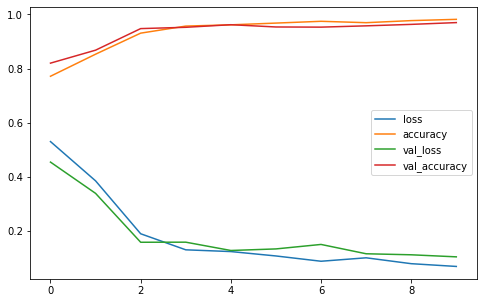

In [59]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = model.fit(X_train_tokens_pad, y_train,
                    batch_size=128, epochs=10, validation_split=0.2)
model.save("email_cat_lstm.h5")

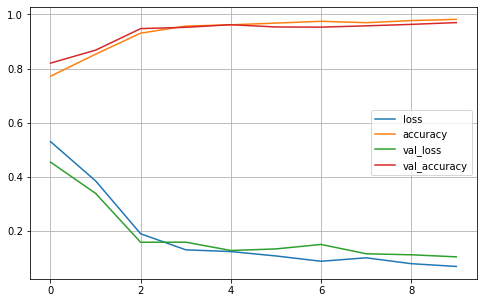

In [61]:
from matplotlib import pyplot as plt
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()

In [60]:
pred_prob = model.predict(X_test_tokens_pad).squeeze()
pred_class = np.asarray(pred_prob > 0.5).astype(np.int32)
id = test['id']
output = pd.DataFrame({'id':id, 'Class': pred_class})
output.to_csv("submission_gru.csv",  index=False)